Dataset Link: https://drive.google.com/drive/folders/1T6sz4LPKPAaNwqDr3TljLNLFcy6jEZ-N?usp=drive_link

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!ls "/content/drive/MyDrive"

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import tensorflow as tf
import cv2
from matplotlib.image import imread
import random
from os import listdir
from PIL import Image
from sklearn.preprocessing import label_binarize, LabelBinarizer
from keras.preprocessing import image
from keras.preprocessing.image import img_to_array, array_to_img
from keras.optimizers import Adam
from keras.models import Sequential, model_from_json
from keras.layers import Dense, MaxPooling2D, Conv2D, Activation, Flatten, Dropout
from sklearn.model_selection import train_test_split
from keras.utils import to_categorical

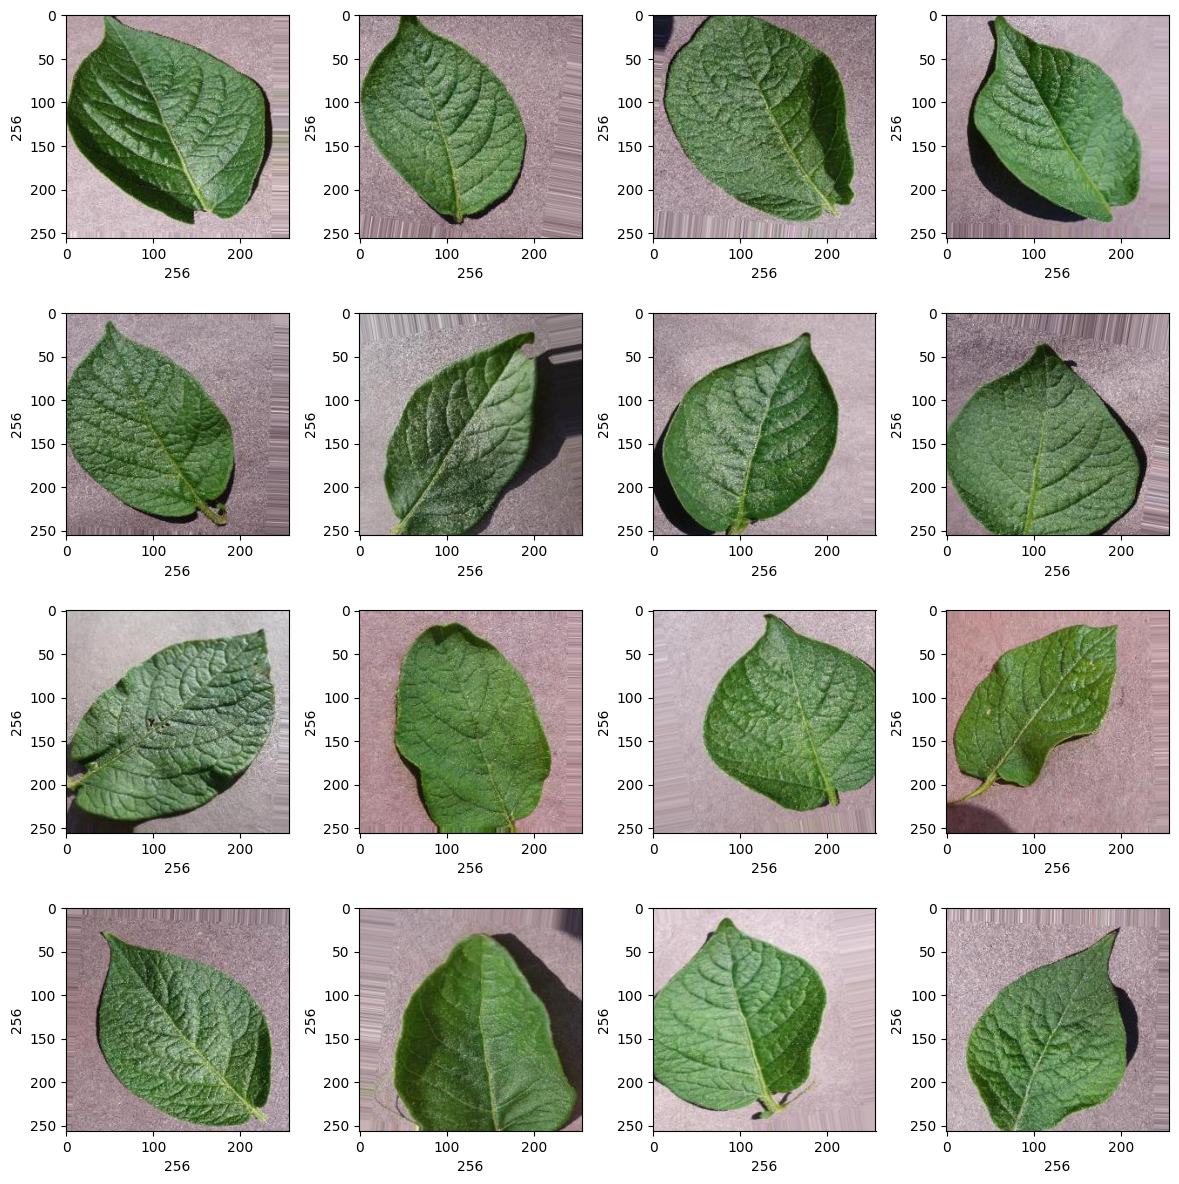

In [4]:
plt.figure(figsize=(12,12))
path = "/content/drive/MyDrive/Potato/Train/Potato___healthy"
for i in range (1,17):
  plt.subplot(4,4,i)
  plt.tight_layout()
  rand_img = imread(path +"/"+ random.choice(sorted(os.listdir(path))))
  plt.imshow(rand_img)
  plt.xlabel(rand_img.shape[1])
  plt.ylabel(rand_img.shape[0])

In [5]:
train_dir = "/content/drive/MyDrive/Potato/Train"
test_dir = "/content/drive/MyDrive/Potato/Test"
valid_dir = "/content/drive/MyDrive/Potato/Valid"

Data Rescaling and augmentation

In [6]:
data_augmentation = tf.keras.Sequential([
  tf.keras.layers.experimental.preprocessing.RandomFlip("horizontal",input_shape=(224, 224, 3)),
  tf.keras.layers.experimental.preprocessing.RandomRotation(0.2),
  tf.keras.layers.experimental.preprocessing.RandomZoom(0.2),
  tf.keras.layers.experimental.preprocessing.RandomHeight(0.2),
  tf.keras.layers.experimental.preprocessing.RandomWidth(0.2),
  tf.keras.layers.experimental.preprocessing.Rescaling(1./255)
], name ="data_augmentation")

In [7]:
IMG_SIZE = (224, 224)
BATCH_SIZE = 32
train_data = tf.keras.preprocessing.image_dataset_from_directory(
    directory = train_dir,
    image_size = IMG_SIZE,
    label_mode = 'categorical',
    batch_size = BATCH_SIZE,
    shuffle = True
).cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

test_data = tf.keras.preprocessing.image_dataset_from_directory(
    directory = test_dir,
    image_size = IMG_SIZE,
    label_mode = 'categorical',
    batch_size = BATCH_SIZE
).cache().prefetch(buffer_size=tf.data.AUTOTUNE)

valid_datasets = tf.keras.preprocessing.image_dataset_from_directory(
    directory = valid_dir,
    image_size = IMG_SIZE,
    label_mode = 'categorical',
    batch_size = BATCH_SIZE
)

class_names = valid_datasets.class_names
valid_data = valid_datasets.cache().prefetch(buffer_size=tf.data.AUTOTUNE)

Found 900 files belonging to 3 classes.
Found 300 files belonging to 3 classes.
Found 300 files belonging to 3 classes.


In [8]:
[(images, label_batch)] = train_data.take(1)
total_classes = label_batch.shape[-1]
total_classes

3

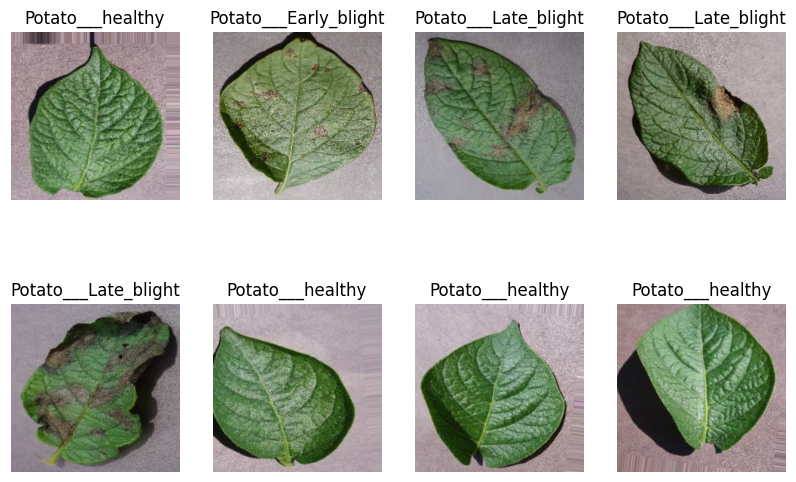

In [9]:
plt.figure(figsize=(10,10))
for image_batch,label_batch in train_data.take(1):
    for i in range(0,8):
        plt.subplot(3,4,i+1)
        plt.imshow(image_batch[i].numpy().astype("uint32"))
        plt.title(class_names[np.argmax(label_batch[i])])
        plt.axis("off")

Create Checkpoint

In [10]:
checkpoint_path = "/CheckPoint/cp.ckpt"
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    checkpoint_path,
    save_weights_only=True,
    monitor='val_accuracy',
    save_best_only=True
)

Creating Model

In [11]:
model = tf.keras.Sequential([
    data_augmentation,
    tf.keras.layers.Conv2D(60, 3, activation='relu'),
    tf.keras.layers.MaxPool2D(pool_size=2),
    tf.keras.layers.Conv2D(60, 3, activation='relu'),
    tf.keras.layers.MaxPool2D(pool_size=2),
    tf.keras.layers.Conv2D(60, 3, activation='relu'),
    tf.keras.layers.MaxPool2D(pool_size=2),
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dense(total_classes, activation='softmax', name='output_layers')
])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 data_augmentation (Sequent  (None, None, None, 3)     0         
 ial)                                                            
                                                                 
 conv2d (Conv2D)             (None, None, None, 60)    1680      
                                                                 
 max_pooling2d (MaxPooling2  (None, None, None, 60)    0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, None, None, 60)    32460     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, None, None, 60)    0         
 g2D)                                                            
                                                        

In [12]:
model.compile(
    loss = 'categorical_crossentropy',
    optimizer = tf.keras.optimizers.Adam(),
    metrics = ['accuracy']
)

In [13]:
history = model.fit(
    train_data,
    epochs=50,
    validation_data = test_data,
    validation_steps = len(test_data),
    callbacks = [
        checkpoint_callback,
    ]
)

Epoch 1/50
29/29 [==============================] - 97s 3s/step - loss: 1.0922 - accuracy: 0.3733 - val_loss: 1.0631 - val_accuracy: 0.3333
Epoch 2/50
29/29 [==============================] - 36s 1s/step - loss: 1.0015 - accuracy: 0.5200 - val_loss: 0.8604 - val_accuracy: 0.6167
Epoch 3/50
29/29 [==============================] - 37s 1s/step - loss: 0.8087 - accuracy: 0.6356 - val_loss: 0.6471 - val_accuracy: 0.7000
Epoch 4/50
29/29 [==============================] - 35s 1s/step - loss: 0.6739 - accuracy: 0.7044 - val_loss: 0.5767 - val_accuracy: 0.6900
Epoch 5/50
29/29 [==============================] - 34s 1s/step - loss: 0.5857 - accuracy: 0.7322 - val_loss: 0.4793 - val_accuracy: 0.7767
Epoch 6/50
29/29 [==============================] - 32s 1s/step - loss: 0.4879 - accuracy: 0.8000 - val_loss: 0.4201 - val_accuracy: 0.8000
Epoch 7/50
29/29 [==============================] - 35s 1s/step - loss: 0.3894 - accuracy: 0.8467 - val_loss: 0.3512 - val_accuracy: 0.8767
Epoch 8/50
29/29 [==

Check best weight validation data percentance

In [14]:
def bestWeightModelEvaluate(model, weight_path, data):
  cp_model = tf.keras.models.clone_model(model)
  cp_model.compile(
      loss = tf.keras.losses.CategoricalCrossentropy(),
      optimizer = tf.keras.optimizers.Adam(),
      metrics = ['accuracy']
  )
  cp_model.load_weights(weight_path)
  cp_model.evaluate(data)

In [15]:
bestWeightModelEvaluate(
    model = model,
    weight_path= checkpoint_path,
    data = valid_data
)

10/10 [==============================] - 49s 251ms/step - loss: 0.1094 - accuracy: 0.9667


In [16]:
bestWeightModelEvaluate(
    model = model,
    weight_path= checkpoint_path,
    data = test_data
)

10/10 [==============================] - 1s 28ms/step - loss: 0.0805 - accuracy: 0.9767


In [17]:
import numpy as np
predictions = model.predict(test_data)
predictions = np.argmax(predictions, axis=-1)
predictions.shape

10/10 [==============================] - 0s 20ms/step


(300,)

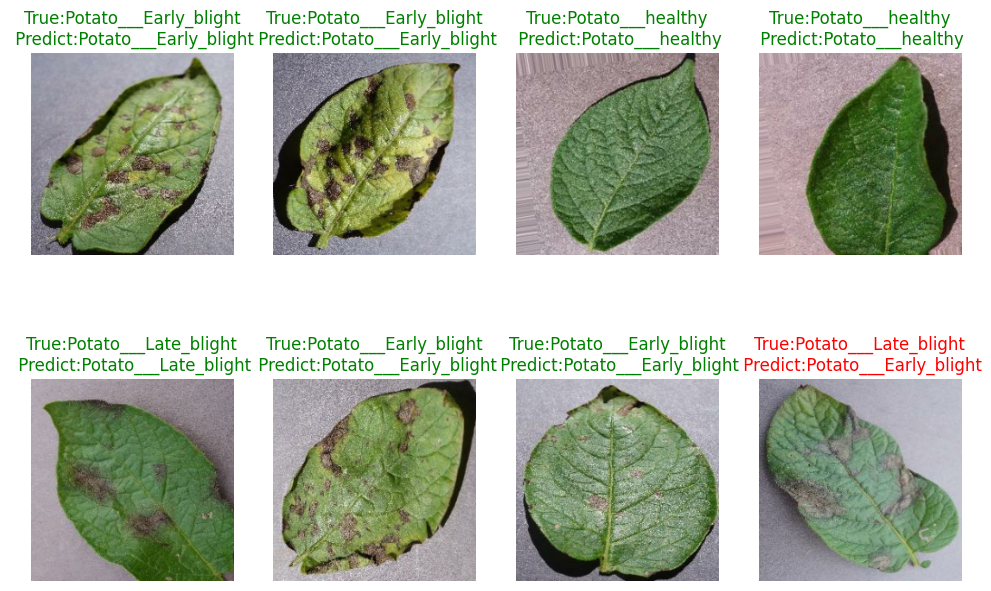

In [18]:
plt.figure(figsize=(12,12))
for image_batch,label_batch in test_data.take(1):
    for i in range(0,8):
        plt.subplot(3,4,i+1)
        plt.imshow(image_batch[i].numpy().astype("uint32"))
        true_class = class_names[np.argmax(label_batch[i])]
        predict_class = class_names[predictions[i]]
        title = f"""True:{true_class}\n Predict:{predict_class}"""
        plt.title(title, color='g' if true_class==predict_class else 'r')
        plt.axis("off")